# Load Data (Similar to Andy's Notebook)

In [25]:
import os, sys
from pathlib import Path
import urllib.request
from collections import Counter, defaultdict
import string
import re
from importlib import reload
import math

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline

import models.fasttext as fasttext
import models.cnn as cnn
reload(fasttext)
reload(cnn);

In [2]:
tv_show = "friends"

In [16]:
nltk.download('punkt')
nltk.download('stopwords')

root_path = Path().resolve().joinpath("..")
show_data_path = root_path.joinpath("scrape", "data", tv_show, "parsed")
embeddings_path = root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors.gz")
embeddings_url = "https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz?dl=1"

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/richung/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/richung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
print(embeddings_path)

/home/richung/final/analysis/../embeddings/newscrawl.300d.W.pos.vectors.gz


In [19]:
if not os.path.isfile(embeddings_path):
    print("downloading embeddings...")
    urllib.request.urlretrieve(embeddings_url, embeddings_path)

!gunzip -f {str(embeddings_path)} 

downloading embeddings...


## Load the training data

In [7]:
dialog_datas = []

for filename in os.listdir(show_data_path):
    dialog_data = pd.read_csv(show_data_path.joinpath(filename), header=None, names=("speaker", "utterance"))
    dialog_data["episode"] = filename.split(".")[0]
    dialog_datas.append(dialog_data)
    
all_dialog_data = pd.concat(dialog_datas).dropna().reset_index(drop=True)

In [8]:
print(all_dialog_data.count())
all_dialog_data.head()

speaker      55025
utterance    55025
episode      55025
dtype: int64


,speaker,utterance,episode
0,Monica,Hey you guys?,0806
1,Ross,What?,0806
2,Monica,"I know it’s last minute, but we decided to hav...",0806
3,Phoebe,Oh good!,0806
4,Monica,And everybody has to wear costumes. Come on! ...,0806


## Data Pre-processing and Minor Analysis (Just to make sure it's the same as Andy's)

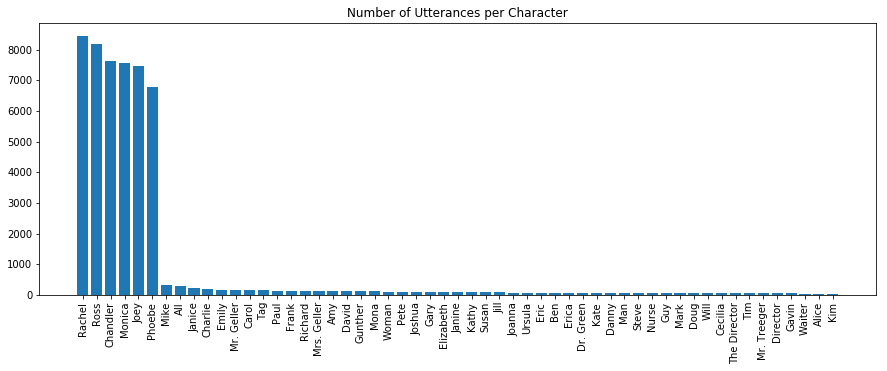

In [9]:
speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(111)
sub.bar(x, y)
for tick in sub.get_xticklabels():
    tick.set_rotation(90)
plt.title("Number of Utterances per Character")
plt.show()

In [10]:
num_major_characters = 6
major_characters = x[:num_major_characters]
major_characters_set = set(major_characters)

In [11]:
labels_to_ids = {}
ids_to_labels = {}
for i, major_character in enumerate(major_characters):
    labels_to_ids[major_character] = i
    ids_to_labels[i] = major_character
labels_to_ids

{'Rachel': 0, 'Ross': 1, 'Chandler': 2, 'Monica': 3, 'Joey': 4, 'Phoebe': 5}

In [12]:
major_dialog_data = all_dialog_data[all_dialog_data.speaker.isin(major_characters_set)]
print(major_dialog_data.count())

speaker      46079
utterance    46079
episode      46079
dtype: int64


In [20]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()

labels = major_dialog_data.speaker

#utterances = list(map(lambda utter: tokenizer.tokenize(utter.lower()), major_dialog_data.utterance))
utterances = [tokenizer.tokenize(utter.lower()) for utter in major_dialog_data.utterance]
embeddings = KeyedVectors.load_word2vec_format(root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors"), binary=False)

Text(0.5,1,'Histogram of Utterance lengths')

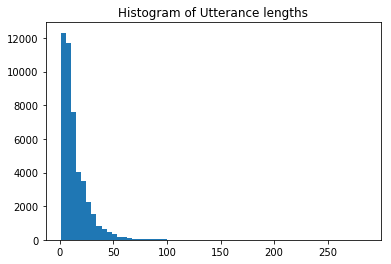

In [21]:
plt.hist([len(words) for words in utterances], bins=60)
plt.title("Histogram of Utterance lengths")

## Baseline Model - Always predict most common class (still copying Andy)

In [22]:
np.mean(labels == major_characters[0])

0.1832939082879403

In [23]:
def shuffle(x, y):
    m = x.shape[0]
    rand_perm = np.random.permutation(m)
    x = x[rand_perm]
    y = y[rand_perm]
    return x, y

def batch_iter(x, y, batch_size):
    num_batches = int(np.ceil(x.shape[0] / batch_size))
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        yield i, x[start:end], y[start:end]

In [26]:
non_empty_utterances = []
non_empty_utterance_labels = []

for i, utterance in enumerate(utterances):
    words = [word for word in utterance if word in embeddings.vocab and word not in stop_words]
    if len(words) > 0:
        non_empty_utterances.append(words)
        non_empty_utterance_labels.append(labels.iloc[i])

bags = np.zeros((len(non_empty_utterances), embeddings.vector_size))

for i, utterance in enumerate(non_empty_utterances):
    words = [word for word in utterance if word in embeddings.vocab]
    vectors = np.zeros((len(words), embeddings.vector_size))
    for j, word in enumerate(words):
        vectors[j, :] = embeddings.word_vec(word)
    bag = np.mean(vectors, axis=0)
    bags[i, :] = bag

train_cut = math.ceil(major_dialog_data.utterance.count() * 0.85)
train_x = bags[0:train_cut]
train_y = non_empty_utterance_labels[0:train_cut]
test_x = bags[train_cut:]
test_y = non_empty_utterance_labels[train_cut:]

print(train_x.shape, test_x.shape)

(39168, 300) (4216, 300)


## Alright, now it's time to do some new stuff